In [7]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import sys

notebook_path = os.path.abspath(".")
sys.path.append(os.path.abspath(os.path.join(notebook_path, '..', 'src')))

import encoding_func

In [8]:
df_modelo = pd.read_pickle('../bin/dataframe_ml.pickle')
df_modelo

,kilometraje,cambio_automatico,potencia,marca_sola,antiguedad,precio
0,12.095147,1,5.505332,BMW,14,9.898525
1,11.904974,1,5.609472,BMW,18,9.510519
2,10.745076,1,5.572154,TOYOTA,6,11.181654
3,12.644331,1,5.942799,LEXUS,18,9.384378
4,11.272012,1,5.726848,TESLA,9,10.791399
...,...,...,...,...,...,...
19885,9.752839,1,5.303305,MERCEDES-BENZ,1,10.776892
19886,10.101108,1,5.303305,MERCEDES-BENZ,1,10.776892
19887,11.577908,1,5.273000,MERCEDES-BENZ,4,10.568775
19888,11.347933,1,4.812184,TOYOTA,4,9.908525


In [9]:
with open(f"../bin/marca_sola_precio_encoder.pickle", "rb") as file:
    marca_sola_precio_encoder = pickle.load(file)

with open(f"../bin/min_max_scaler.pickle", "rb") as file:
    min_max_scaler = pickle.load(file)   

In [10]:
# Probar con one hot encoding en su lugar para marca
# encoding_func.generar_pickle_onehot_encoding(df_modelo, ['marca_sola'])

In [11]:
# with open(f"../bin/marca_sola_precio_encoder.pickle", "rb") as file:
#     marca_sola_encoder = pickle.load(file)

# with open(f"../bin/min_max_scaler.pickle", "rb") as file:
#     min_max_scaler = pickle.load(file)   

In [12]:
TARGET = "precio"

X_train, X_test, y_train, y_test = encoding_func.dividir_dataframe(df_modelo, TARGET, test_size=0.2, random_state=42)

X_train["marca_sola"] = marca_sola_precio_encoder.transform(X_train["marca_sola"])
X_test["marca_sola"] = marca_sola_precio_encoder.transform(X_test["marca_sola"])

X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)


In [13]:
# scaler = MinMaxScaler()
# scaler.set_output(transform="pandas")

# X_train_escalado = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test_escalado = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [14]:
X_train

,kilometraje,cambio_automatico,potencia,marca_sola,antiguedad
18983,0.731146,0.0,0.503202,0.250029,0.033333
6177,0.875992,1.0,0.598995,0.369963,0.133333
10801,0.676674,0.0,0.443408,0.190508,0.033333
177,0.916511,1.0,0.549681,0.212039,0.300000
3932,0.810555,1.0,0.684449,0.491206,0.066667
...,...,...,...,...,...
11891,0.776087,1.0,0.503202,0.077735,0.100000
12761,0.906479,1.0,0.598995,0.502655,0.266667
5559,0.828474,1.0,0.592297,0.377722,0.100000
868,0.431142,1.0,0.519865,0.073555,0.033333


#### RED NEURONAL DE REGRESIÓN ####

In [17]:
def crear_modelo(numero_entradas):
    """Crea un modelo de red neuronal secuencial para regresión."""
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(units=64, activation='relu', input_dim=numero_entradas))
    model.add(Dense(units=32, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))

    # learning_rate = 0.01  # Ajusta este valor
    # optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()

    return model

def entrenar_modelo(model, X_train, y_train, epochs=100, batch_size=32):
    """Entrena el modelo de red neuronal y guarda el historial de entrenamiento."""
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=15,
                                   restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stopping])
     
    return model, history

def obtener_predicciones(model, X_test):
    """Obtiene las predicciones del modelo."""
    return model.predict(X_test).flatten()

def evaluar_modelo(y_test, y_pred):
    """Evalúa el rendimiento del modelo de regresión."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

def graficar_historial(history):
    """Grafica el historial de entrenamiento (loss y MAE) y guarda la imagen."""
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss vs. Epochs", "MAE vs. Epochs"))

    # Gráfica de Loss
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['loss']))),
        y=history.history['loss'],
        mode='lines',
        name='Training Loss'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['val_loss']))),
        y=history.history['val_loss'],
        mode='lines',
        name='Validation Loss'
    ), row=1, col=1)

    # Gráfica de MAE
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['mae']))),
        y=history.history['mae'],
        mode='lines',
        name='Training MAE'
    ), row=1, col=2)
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history['val_mae']))),
        y=history.history['val_mae'],
        mode='lines',
        name='Validation MAE'
    ), row=1, col=2)

    fig.update_layout(
        title_text='Training History',
        xaxis_title='Epochs',
        yaxis_title='Loss',
        yaxis2=dict(
            title='MAE',
            overlaying='y',
            side='right'
        ),
        legend=dict(
            x=1,
            y=1,
            xanchor='right',
            yanchor='top',
            font=dict(size=10),
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        )
    )

    # Guardar la imagen
    #fig.write_image('../img/graficas_dl.png')
    #fig.show()

def main(X_train, X_test, y_train, y_test):
    """Función principal que ejecuta todo el proceso de modelado."""
    model = crear_modelo(X_train.shape[1])
    model, history = entrenar_modelo(model, X_train, y_train)

    model.save('../bin/modelo_dl.keras')
    with open('../bin/modelo_dl_architecture.json', 'w') as json_file:
        json_file.write(model.to_json())

    with open('../bin/history_dl.pickle', 'wb') as file:
        pickle.dump(history.history, file)

    y_pred = obtener_predicciones(model, X_test)
    mse, mae, r2 = evaluar_modelo(y_test, y_pred)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    df_metrics = pd.DataFrame({
        'MSE': [mse],
        'MAE': [mae],
        'R2': [r2]
    })
    with open('../bin/metrics_dl.pickle', 'wb') as file:
        pickle.dump(df_metrics, file)

    graficar_historial(history)

In [18]:
main(X_train, X_test, y_train, y_test)
#X_train[:19]

e:\hackABoss\pfb-coches\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 36.3021 - mae: 4.7001 - val_loss: 0.4400 - val_mae: 0.4534
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2791 - mae: 0.3560 - val_loss: 0.0938 - val_mae: 0.2260
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0870 - mae: 0.2123 - val_loss: 0.0671 - val_mae: 0.1882
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0736 - mae: 0.1921 - val_loss: 0.0601 - val_mae: 0.1749
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0598 - mae: 0.1746 - val_loss: 0.0570 - val_mae: 0.1700
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0574 - mae: 0.1684 - val_loss: 0.0551 - val_mae: 0.1641
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0659 - mae: 0.1699 - val_loss: 0.0543 - val_mae: 0.1640
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0601 - mae: 0.1671 - val_loss: 0.0536 - val_mae: 0.1608
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

In [53]:
modelo = tf.keras.models.load_model("../bin/modelo_dl.keras")

y_pred = obtener_predicciones(modelo, X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [54]:
np.exp(y_pred[0])

np.float32(8437.26)

#### RED NEURONAL DENSA ####

In [59]:
def crear_dnn(input_dim):
    """Crea una Red Neuronal Densa (DNN) para regresión."""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    model.summary()
   

    return model

def entrenar_dnn(model, X_train, y_train, epochs=100, batch_size=32):
    """Entrena la DNN y guarda el historial de entrenamiento."""
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2)
    
    return model, history

def obtener_predicciones_dnn(model, X_test):
    """Obtiene las predicciones de la DNN."""
    return model.predict(X_test).flatten()

def evaluar_dnn(y_test, y_pred):
    """Evalúa el rendimiento de la DNN."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

def graficar_historial_dnn(history):
    """Grafica el historial de entrenamiento (loss y MAE)."""
    plt.figure(figsize=(12, 5))

    # Gráfica de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

def main_dnn(X_train, X_test, y_train, y_test):
    """Función principal que ejecuta todo el proceso de modelado con la DNN."""
    model = crear_dnn(X_train.shape[1])
    model, history = entrenar_dnn(model, X_train, y_train)

    y_pred = obtener_predicciones_dnn(model, X_test)
    mse, mae, r2 = evaluar_dnn(y_test, y_pred)

    print(f"DNN - MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    graficar_historial_dnn(history)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28.7904 - mae: 3.7579 - val_loss: 0.0865 - val_mae: 0.2123
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0726 - mae: 0.2015 - val_loss: 0.0692 - val_mae: 0.1807
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0616 - mae: 0.1806 - val_loss: 0.0651 - val_mae: 0.1731
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0558 - mae: 0.1701 - val_loss: 0.0608 - val_mae: 0.1619
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0514 - mae: 0.1644 - val_loss: 0.0564 - val_mae: 0.1548
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.0488 - mae: 0.1588 - val_loss: 0.0562 - val_mae: 0.1546
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0506 - mae: 0.1624 - val_loss: 0.0577 - val_mae: 0.1613
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0503 - mae: 0.1627 - val_loss: 0.0541 - val_mae: 0.1510
Epoch 9/100
321/321 ━━━━━━━━━━━━━

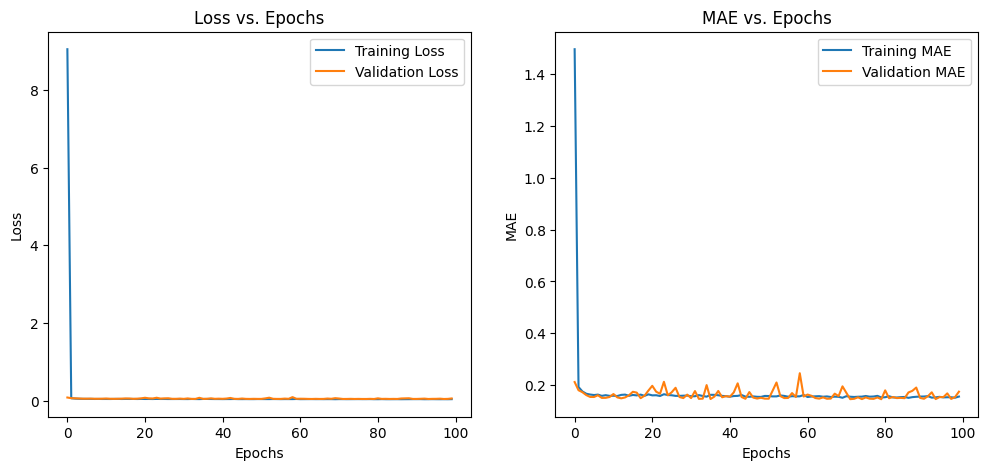

In [60]:
main_dnn(X_train, X_test, y_train, y_test)

#### RED NEURONAL DE REGRESIÓN CON DISTINTOS PARÁMETROS ####

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input

def crear_modelo(entradas):
    """Crea un modelo de red neuronal secuencial para regresión."""
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(units = 64, activation='relu', input_dim=entradas))

    model.add(Dense(units = 32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    model.summary()
    
    return model

def entrenar_modelo(model, X_train, y_train, epochs=100):
    """Entrena el modelo de red neuronal y guarda el historial de entrenamiento."""
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_split=0.2)
    return model, history

def obtener_predicciones(model, X_test):
    """Obtiene las predicciones del modelo."""
    return model.predict(X_test).flatten()

def evaluar_modelo(y_test, y_pred):
    """Evalúa el rendimiento del modelo de regresión."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

def graficar_historial(history):
    """Grafica el historial de entrenamiento (loss y MAE)."""
    plt.figure(figsize=(12, 5))

    # Gráfica de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

def main_otrosp(X_train, X_test, y_train, y_test):
    """Función principal que ejecuta todo el proceso de modelado."""
    model = crear_modelo(X_train.shape[1])
    model, history = entrenar_modelo(model, X_train, y_train)

    y_pred = obtener_predicciones(model, X_test)
    mse, mae, r2 = evaluar_modelo(y_test, y_pred)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    graficar_historial(history)

/home/bross/Codigo_HAB/PFB_coches/PFB_coches/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43.2037 - mae: 5.4528 - val_loss: 0.6470 - val_mae: 0.5467
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.9822 - mae: 1.1230 - val_loss: 0.1281 - val_mae: 0.2411
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.6289 - mae: 1.0169 - val_loss: 0.1044 - val_mae: 0.2284
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.6341 - mae: 1.0158 - val_loss: 0.1212 - val_mae: 0.2644
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 1.6014 - mae: 1.0021 - val_loss: 0.1014 - val_mae: 0.2351
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 1.5012 - mae: 0.9707 - val_loss: 0.0978 - val_mae: 0.2332
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.5214 - mae: 0.9734 - val_loss: 0.1236 - val_mae: 0.2696
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.5634 - mae: 0.9869 - val_loss: 0.0851 - val_mae: 0.2080
Epoch 9/100
321/321 ━━━━━━━━━━━━━

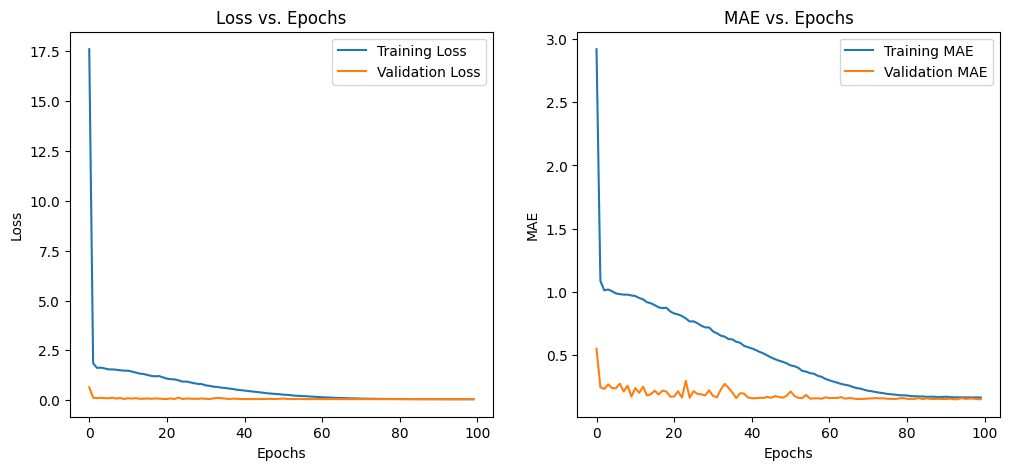

In [62]:
main_otrosp(X_train, X_test, y_train, y_test)

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input

def crear_modelo(entradas):
    """Crea un modelo de red neuronal secuencial para regresión."""
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(units = 64, activation='relu', input_dim=entradas))

    model.add(Dense(units = 32, activation='relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(units = 1, activation='linear'))

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    model.summary()
    
    return model

def entrenar_modelo(model, X_train, y_train, epochs=100):
    """Entrena el modelo de red neuronal y guarda el historial de entrenamiento."""
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_split=0.2)
    return model, history

def obtener_predicciones(model, X_test):
    """Obtiene las predicciones del modelo."""
    return model.predict(X_test).flatten()

def evaluar_modelo(y_test, y_pred):
    """Evalúa el rendimiento del modelo de regresión."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

def graficar_historial(history):
    """Grafica el historial de entrenamiento (loss y MAE)."""
    plt.figure(figsize=(12, 5))

    # Gráfica de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

def main_otrosp(X_train, X_test, y_train, y_test):
    """Función principal que ejecuta todo el proceso de modelado."""
    model = crear_modelo(X_train.shape[1])
    model, history = entrenar_modelo(model, X_train, y_train)

    y_pred = obtener_predicciones(model, X_test)
    mse, mae, r2 = evaluar_modelo(y_test, y_pred)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    graficar_historial(history)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.9710 - mae: 6.0269 - val_loss: 0.3237 - val_mae: 0.4165
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.1760 - mae: 0.3034 - val_loss: 0.0794 - val_mae: 0.2005
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0661 - mae: 0.1923 - val_loss: 0.0679 - val_mae: 0.1799
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0610 - mae: 0.1797 - val_loss: 0.0624 - val_mae: 0.1677
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0531 - mae: 0.1675 - val_loss: 0.0606 - val_mae: 0.1639
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0519 - mae: 0.1639 - val_loss: 0.0631 - val_mae: 0.1705
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0518 - mae: 0.1623 - val_loss: 0.0594 - val_mae: 0.1612
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0494 - mae: 0.1595 - val_loss: 0.0612 - val_mae: 0.1624
Epoch 9/100
321/321 ━━━━━━━━━━━━━

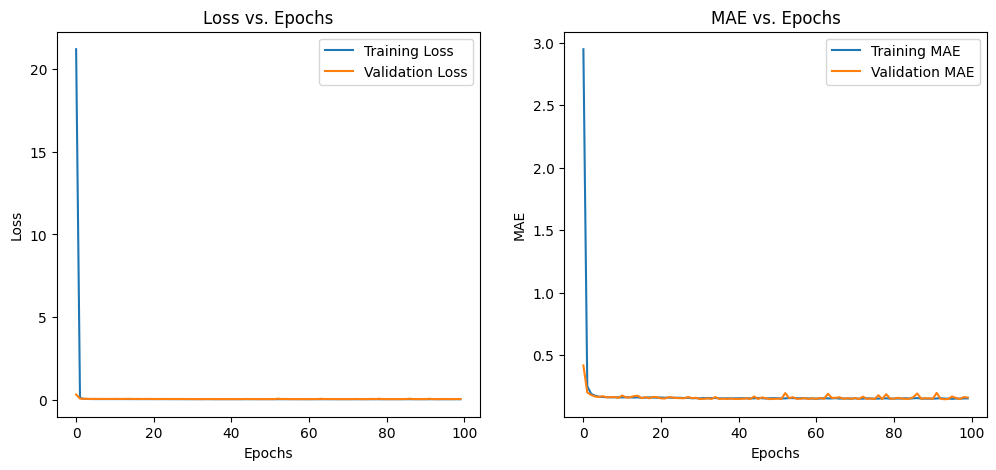

In [82]:
main_otrosp(X_train, X_test, y_train, y_test)